In [1]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.0 MB/s eta 0:00:00


In [2]:
import os

## 0. Get data

### 0.1 Install data from kaggle

In [3]:
!mkdir -p /root/.kaggle

In [4]:
os.replace('/root/kaggle.json', '/root/.kaggle/kaggle.json')

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
import kaggle

import zipfile
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import MeanSquaredError
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

from typing import Tuple, List, Dict

In [7]:
!ls

sample_data


In [8]:
!pwd

/content


In [9]:
!pwd
os.mkdir('data')
os.chdir('/content/data')
!pwd

/content
/content/data


In [10]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:50<00:00, 29.7MB/s]
100% 1.33G/1.33G [00:50<00:00, 28.3MB/s]


In [11]:
!pwd
os.chdir('/content')
!pwd

/content/data
/content


### 0.2 Unziping file

In [12]:
data_dir = Path('data')
zipped_dataset_name = 'celeba-dataset.zip'
with zipfile.ZipFile(data_dir / zipped_dataset_name, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

os.remove(data_dir / zipped_dataset_name)

### 0.3 Get DataFrames

In [13]:
df_landmarks = pd.read_csv(data_dir / 'list_landmarks_align_celeba.csv')

In [14]:
print(f'There are {df_landmarks.isna().sum().sum()} missing values in df_landmarks')

There are 0 missing values in df_landmarks


In [15]:
images_dir = data_dir / "img_align_celeba" / "img_align_celeba"

print(f'There is {len(os.listdir(images_dir))} images in data_dir / img_align_celeba / img_align_celeba')

There is 202599 images in data_dir / img_align_celeba / img_align_celeba


In [16]:
print(f'Shape of df_landmarks is {df_landmarks.shape}')

Shape of df_landmarks is (202599, 11)


### 0.4 Device agnostic

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Data Exploration

In [18]:
df_landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [19]:
df_landmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_id      202599 non-null  object
 1   lefteye_x     202599 non-null  int64 
 2   lefteye_y     202599 non-null  int64 
 3   righteye_x    202599 non-null  int64 
 4   righteye_y    202599 non-null  int64 
 5   nose_x        202599 non-null  int64 
 6   nose_y        202599 non-null  int64 
 7   leftmouth_x   202599 non-null  int64 
 8   leftmouth_y   202599 non-null  int64 
 9   rightmouth_x  202599 non-null  int64 
 10  rightmouth_y  202599 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 17.0+ MB


In [20]:
df_landmarks.describe()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,69.353867,111.197982,107.644031,111.161600,88.063140,135.102024,71.247459,152.113011,105.586429,152.194660
std,1.717952,1.129284,1.690252,1.169229,6.647733,4.245078,3.168011,1.799343,3.233125,1.752368
min,56.000000,98.000000,90.000000,95.000000,57.000000,93.000000,57.000000,116.000000,82.000000,114.000000
25%,68.000000,111.000000,107.000000,111.000000,84.000000,133.000000,69.000000,151.000000,103.000000,151.000000
50%,69.000000,111.000000,108.000000,111.000000,88.000000,135.000000,72.000000,152.000000,105.000000,152.000000
75%,70.000000,112.000000,109.000000,112.000000,92.000000,138.000000,73.000000,153.000000,108.000000,153.000000
max,88.000000,129.000000,124.000000,122.000000,121.000000,156.000000,90.000000,174.000000,120.000000,173.000000


In [21]:
def plot_some_images(images_index):
  img_size = (100,100)

  fig, axs = plt.subplots(nrows=len(images_index)//3+1, ncols=3, figsize=(5, len(images_index)), constrained_layout=True)

  for i, ax in enumerate(axs.ravel()):
    if i > len(images_index) - 1:
      ax.axis(False)
      continue
    else:
      try:
        image = Image.open(images_dir / images_index[i]).resize(img_size)

        ax.imshow(image)
      except:
        print(f'There is no image with index {images_index[i]}')

    ax.set_xticks([])
    ax.set_yticks([])

  #plt.subplots_adjust(wspace=0, hspace=0)
  plt.suptitle(f'{len(images_index)} images of people')

  plt.axis(False)

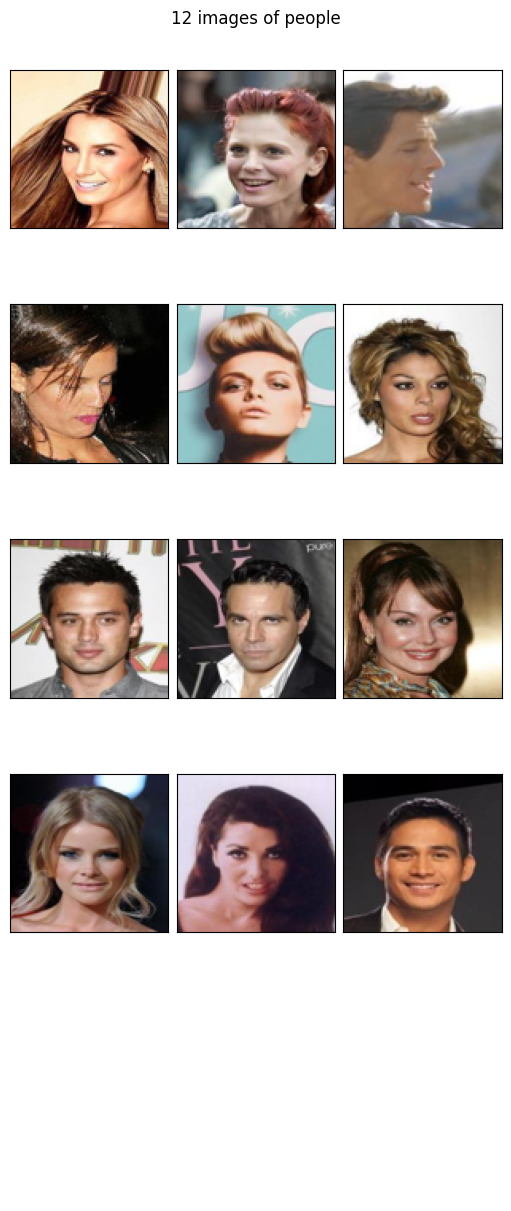

In [22]:
plot_some_images(df_landmarks['image_id'][:12])

### 1.1 Data validation

Let's check for anything unreal ( for example: long distance between lips )

In [23]:
df_landmarks_euclidean = pd.DataFrame(df_landmarks['image_id'])

df_landmarks_euclidean['eyes_distance'] = np.sqrt((df_landmarks['lefteye_x'] - df_landmarks['righteye_x'])**2 + (df_landmarks['lefteye_y'] - df_landmarks['righteye_y'])**2)
df_landmarks_euclidean['lips_distance'] = np.sqrt((df_landmarks['leftmouth_x'] - df_landmarks['rightmouth_x'])**2 + (df_landmarks['leftmouth_y'] - df_landmarks['rightmouth_y'])**2)
df_landmarks_euclidean['left_eye_nose_distance'] = np.sqrt((df_landmarks['lefteye_x'] - df_landmarks['nose_x'])**2 + (df_landmarks['lefteye_y'] - df_landmarks['nose_y'])**2)
df_landmarks_euclidean['right_eye_nose_distance'] = np.sqrt((df_landmarks['righteye_x'] - df_landmarks['nose_x'])**2 + (df_landmarks['righteye_y'] - df_landmarks['nose_y'])**2)
df_landmarks_euclidean['left_mouth_nose_distance'] = np.sqrt((df_landmarks['leftmouth_x'] - df_landmarks['nose_x'])**2 + (df_landmarks['leftmouth_y'] - df_landmarks['nose_y'])**2)
df_landmarks_euclidean['right_mouth_nose_distance'] = np.sqrt((df_landmarks['rightmouth_x'] - df_landmarks['nose_x'])**2 + (df_landmarks['rightmouth_y'] - df_landmarks['nose_y'])**2)

In [24]:
df_landmarks_euclidean.head()

,image_id,eyes_distance,lips_distance,left_eye_nose_distance,right_eye_nose_distance,left_mouth_nose_distance,right_mouth_nose_distance
0,000001.jpg,37.215588,35.057096,33.955854,41.012193,10.770330,33.241540
1,000002.jpg,38.052595,38.052595,27.730849,34.713110,19.416488,32.449961
2,000003.jpg,28.635642,24.083189,35.777088,22.360680,44.045431,31.622777
3,000004.jpg,36.345564,30.265492,38.288379,30.805844,34.481879,13.000000
4,000005.jpg,46.043458,33.136083,20.615528,26.925824,31.764760,35.846897


In [25]:
def plot_boxplots(data=df_landmarks_euclidean, columns=df_landmarks_euclidean.columns[1:]):
  fig, axs = plt.subplots(nrows=len(columns)//2+1, ncols=2, figsize=(10, len(columns)*2))

  for i, ax in enumerate(axs.ravel()):
    if i > len(columns) - 1:
      ax.axis(False)
    else:
      sns.boxplot(data=data, y=columns[i], ax=ax)
      ax.set_title(f'{columns[i]} boxplot')

  plt.suptitle('Boxplots')

  plt.tight_layout()
  plt.show()

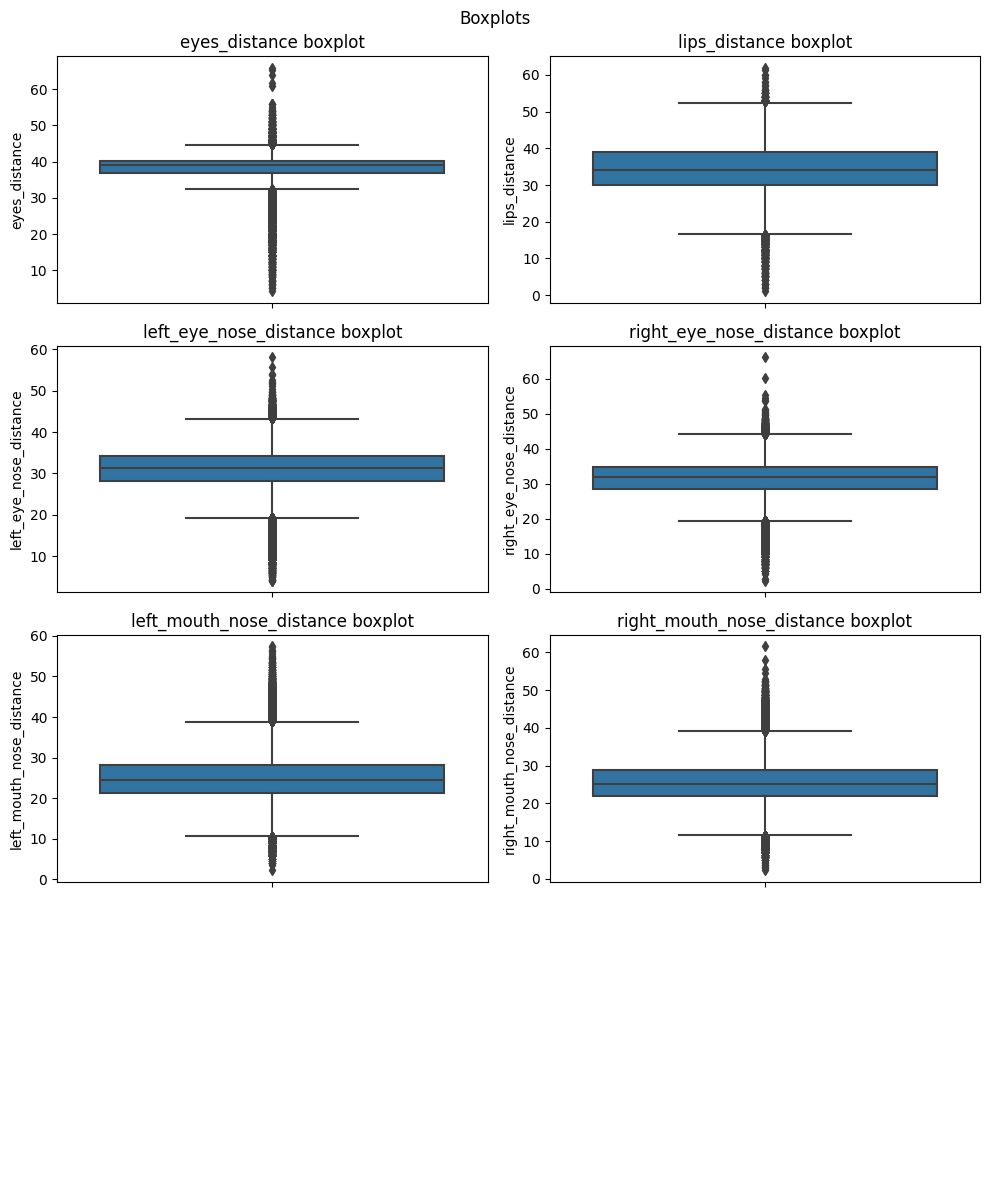

In [26]:
plot_boxplots()

**Summary**:

The data is good.

There are many outliers as a function of Euclidean distance, but all of them (or most of them) are due to the distance to the camera in the image.

There is not a single image where the distance between lips, eyes, or anything else is greater than or nearly the size of the image.

In [27]:
# TO REMOVE
df_landmarks_copy = df_landmarks.copy()

In [128]:
df_landmarks = df_landmarks_copy.copy()

## 2. Data Preparation

In [129]:
images_data_size = 20000

# Original image shape
x_org = 178
y_org = 218

# New image dimensions
x_ = 100
image_size_ratio = x_org / y_org
y_ = int(image_size_ratio * x_)

# Image Sizes
original_image_size = (x_org, y_org)
image_size_training = (224,224)

In [130]:
df_landmarks = df_landmarks.iloc[:images_data_size]

### 2.1 Read images

In [131]:
def array_of_image(index: str,
                   size: Tuple[int, int] = image_size_training,
                   images_path: Path = images_dir):

  path = images_path / index

  image = Image.open(path).resize(size)
  image_array = np.asarray(image)

  return image_array

In [132]:
def plot_image_with_box(index: str,
                        df: pd.DataFrame = df_landmarks,
                        size: Tuple[int, int] = original_image_size):

  image = array_of_image(index, size)
  points = df.set_index('image_id').loc[index, :]

  le_x, le_y, re_x, re_y = points[0], points[1], points[2], points[3]
  n_x, n_y = points[4], points[5]
  lm_x, lm_y, rm_x, rm_y = points[6], points[7], points[8], points[9]

  fig, ax = plt.subplots()

  ax.imshow(image)
  ax.plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'bo-')

  width = abs(le_x-rm_x-60)
  height = abs(le_y-rm_y-75)
  rect = patches.Rectangle((le_x-30, le_y-40), width, height, linewidth=4, edgecolor='g', facecolor='none')

  ax.add_patch(rect)

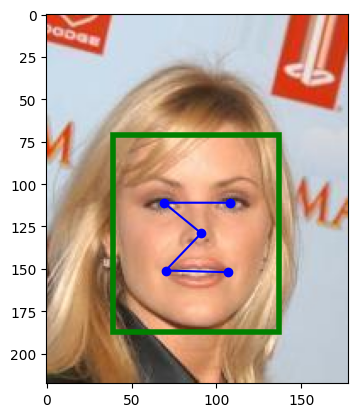

In [133]:
plot_image_with_box('000029.jpg')

### 2.2 Make data adaptive to image size

In [134]:
def update_points(data=df_landmarks, oldsize=original_image_size, new_size=image_size_training):
  df = data.copy()

  x_old, y_old = oldsize

  x_new, y_new = new_size

  x_ratio = x_new / x_old
  y_ratio = y_new / y_old

  keypoints_x = ['lefteye_x', 'righteye_x', 'nose_x', 'leftmouth_x', 'rightmouth_x']
  keypoints_y = ['lefteye_y', 'righteye_y', 'nose_y', 'leftmouth_y', 'rightmouth_y']

  df[keypoints_x] = (df[keypoints_x] * x_ratio).astype('int')
  df[keypoints_y] = (df[keypoints_y] * y_ratio).astype('int')

  return df

In [135]:
df_landmarks = update_points(df_landmarks)

In [136]:
df_landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,86,112,133,116,96,145,91,156,135,158
1,000002.jpg,86,113,134,115,101,138,88,155,135,157
2,000003.jpg,95,115,130,108,135,131,93,160,123,162
3,000004.jpg,90,116,135,110,127,141,89,159,127,155
4,000005.jpg,83,117,140,115,108,122,89,151,130,154


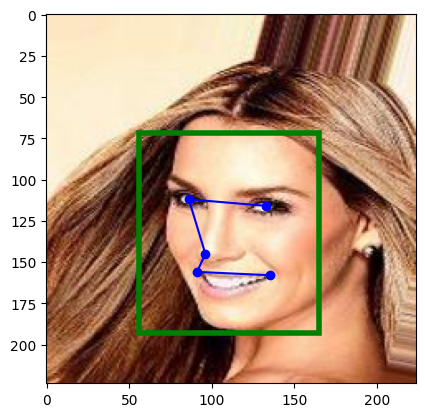

In [140]:
plot_image_with_box('000001.jpg', df_landmarks, image_size_training)

In [141]:
def train_test_xy_generator(data: pd.DataFrame = df_landmarks,
                  img_size: Tuple[int, int] = image_size_training):
  df = data.copy()
  df = df.set_index('image_id')

  x_, y_ = [], []

  for index, target in df.iterrows():
      im = Image.open(images_dir / index).convert('RGB')
      im = im.resize(size=img_size)

      x_.append(im)
      y_.append(target.to_list())

  X_train, X_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

  X_y_train = [(x,y) for x, y in zip(X_train, y_train)]
  X_y_test = [(x,y) for x, y in zip(X_test, y_test)]

  return X_y_train, X_y_test

In [142]:
X_y_train, X_y_test = train_test_xy_generator()

## 3. Image preprocessing

In [143]:
BATCH_SIZE = 32

In [144]:
class CustomDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, label = self.data[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [145]:
train_transformer = transforms.Compose([
      transforms.Resize(image_size_training),
      transforms.CenterCrop(image_size_training),
      transforms.RandomChoice( [
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ColorJitter(contrast=0.9),
                                transforms.ColorJitter(brightness=0.1),
                                transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                ] ),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_transformer = transforms.Compose([
      transforms.Resize(image_size_training),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

In [146]:
train_data = CustomDataset(X_y_train, transform=train_transformer)
test_data = CustomDataset(X_y_test, transform=test_transformer)

def collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    labels = torch.tensor(labels)
    return images, labels

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## 4. Model

In [147]:
class FaceDetectionModel(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_layers):
        super(FaceDetectionModel, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_layers, hidden_layers, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=7, stride=1, padding=3),
            nn.GELU(),
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=7, stride=1, padding=3),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=7, stride=1, padding=3),
            nn.GELU(),
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=7, stride=1, padding=3),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_layers*28*28, out_features=output_layers)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return self.fc1(x)

### 4.1 Model training

In [148]:
INPUT_LAYERS = 3 # Number of colors
HIDDEN_LAYERS = 10 # Hidden layers
OUTPUT_LAYERS = len(X_y_train[0][1]) # Number of features to predict

In [149]:
def metric(preds, targets):
  """Calculates the mean absolute error for multiple outputs.

  Args:
    preds: A tensor of predicted values, with shape (batch_size, num_outputs).
    targets: A tensor of actual values, with shape (batch_size, num_outputs).

  Returns:
    A tensor of the mean absolute error, with shape (1,).
  """

  # Calculate the difference between the predicted and actual values.
  diffs = preds - targets

  # Take the absolute value of the differences.
  abs_diffs = torch.abs(diffs)

  # Average the absolute values of the differences for each sample.
  mae_per_sample = abs_diffs.sum(dim=1) / abs_diffs.shape[1]

  # Average the results from step 3 across all samples.
  mae = mae_per_sample.mean()

  return mae

In [150]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = FaceDetectionModel(INPUT_LAYERS, HIDDEN_LAYERS, OUTPUT_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

# scheduler = StepLR(optimizer=optimizer,
#                    step_size=15,
#                    gamma=0.1,
#                    last_epoch=-1,
#                    verbose=True)

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

NUM_EPOCHS = 25
loss_min = np.inf

for epoch in tqdm(range(NUM_EPOCHS)):
  model.train()

  train_loss = 0

  list_of_mae_train = 0

  for X_train, y_train in train_dataloader:
    X_train = torch.stack(X_train).to(device)
    y_train = y_train.type(torch.float32).to(device)

    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    list_of_mae_train += metric(y_pred, y_train)

  train_loss = train_loss / len(train_dataloader)
  train_mae = list_of_mae_train.cpu() / len(train_dataloader)

  test_loss = 0

  list_of_mae_test = 0

  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      X_test = torch.stack(X_test).to(device)
      y_test = y_test.type(torch.float32).to(device)

      test_pred = model(X_test)

      loss = loss_fn(test_pred, y_test)
      test_loss += loss.item()

      list_of_mae_test += metric(test_pred, y_test)

  test_loss = test_loss / len(test_dataloader)
  test_mae = list_of_mae_test.cpu() / len(test_dataloader)

  # scheduler.step()

  if test_loss < loss_min:
    loss_min = test_loss
    torch.save(model.state_dict(), 'myModel3.pth')
    print(f'Epoch: {epoch+1} | Model loss is {test_loss} | Save model to "/content/myModel3.pth".')

  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_mae)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_mae)

  print(f'Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train MAE: {train_mae:.2f} | Test loss: {test_loss:.5f} | Test MAE: {test_mae:.2f}')


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | Model loss is 22.699285163879395 | Save model to "/content/myModel3.pth".
Epoch: 1 | Train Loss: 54736.80516 | Train MAE: 23.04 | Test loss: 22.69929 | Test MAE: 3.43
Epoch: 2 | Train Loss: 256021.67571 | Train MAE: 35.52 | Test loss: 209.91007 | Test MAE: 10.98
Epoch: 3 | Train Loss: 189.24321 | Train MAE: 10.58 | Test loss: 185.67845 | Test MAE: 12.11
Epoch: 4 | Train Loss: 778.66310 | Train MAE: 10.58 | Test loss: 93.43028 | Test MAE: 8.13
Epoch: 5 | Model loss is 20.334052268981935 | Save model to "/content/myModel3.pth".
Epoch: 5 | Train Loss: 453.60528 | Train MAE: 8.34 | Test loss: 20.33405 | Test MAE: 2.90
Epoch: 6 | Model loss is 14.568887725830079 | Save model to "/content/myModel3.pth".
Epoch: 6 | Train Loss: 26.13471 | Train MAE: 3.74 | Test loss: 14.56889 | Test MAE: 2.48
Epoch: 7 | Train Loss: 27.81969 | Train MAE: 3.98 | Test loss: 22.38934 | Test MAE: 3.69
Epoch: 8 | Train Loss: 27.17983 | Train MAE: 3.95 | Test loss: 15.01864 | Test MAE: 2.55
Epoch: 9 | Trai

In [51]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = [x.detach().numpy() for x in results["train_acc"]]
    test_accuracy = results["test_acc"]
    epochs = list(map(str,range(1,len(results["train_loss"])+1)))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_mae")
    plt.plot(epochs, test_accuracy, label="test_mae")
    plt.title("Mean Absolute Error")
    plt.xlabel("Epochs")
    plt.legend()

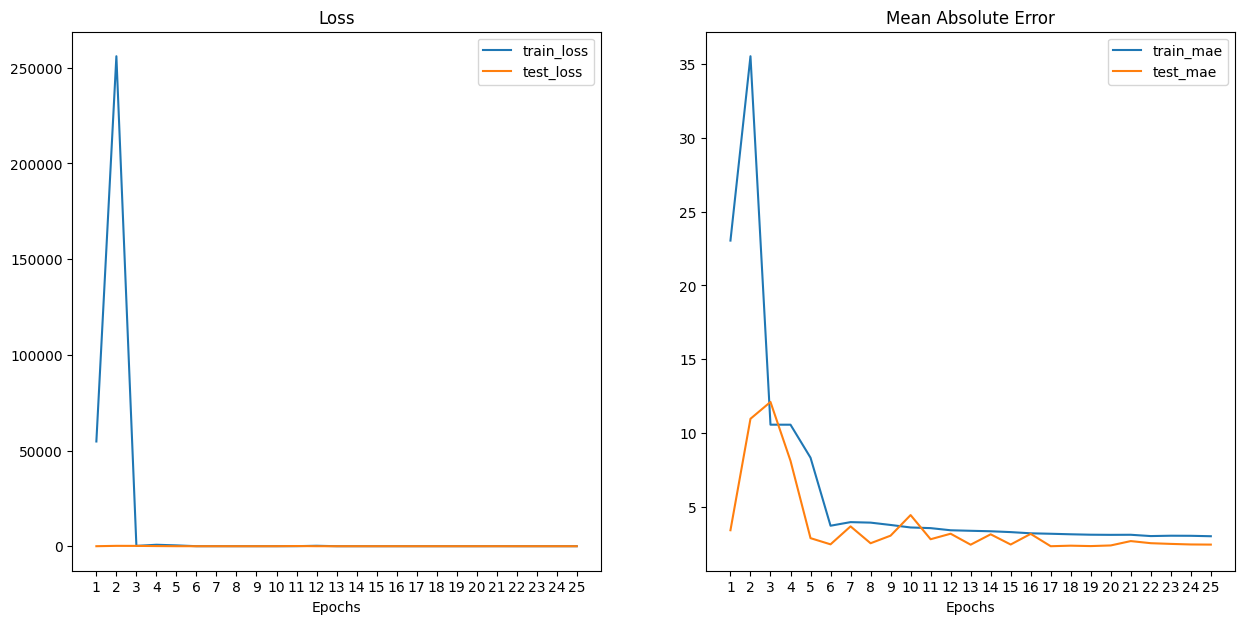

In [151]:
plot_loss_curves(results)

In [121]:
def pred_and_plot_image_with_box(image_path: str,
                                  transform = test_transformer,
                                  size: Tuple[int, int] = original_image_size,
                                  model: nn.Module = model.to('cpu')):

  image = Image.open(image_path).resize((224,224))

  if transform:
    target_image = transform(image)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image)

  #x_ratio = 1 * (original_image_size[0] / image_size_training[0])
  #y_ratio = 1 * (original_image_size[1] / image_size_training[1])
  x_ratio, y_ratio = 1, 1

  points = target_image_pred[0]

  le_x, le_y, re_x, re_y = int(points[0] * x_ratio), int(points[1] * y_ratio), int(points[2] * x_ratio), int(points[3] * y_ratio)
  n_x, n_y = int(points[4] * x_ratio), int(points[5] * y_ratio)
  lm_x, lm_y, rm_x, rm_y = int(points[6] * x_ratio), int(points[7] * y_ratio), int(points[8] * x_ratio), int(points[9] * y_ratio)

  fig, ax = plt.subplots()

  ax.imshow(image)
  ax.plot([re_x, le_x, n_x, lm_x, rm_x], [re_y, le_y, n_y, lm_y, rm_y], 'mo-')

  plt.show()

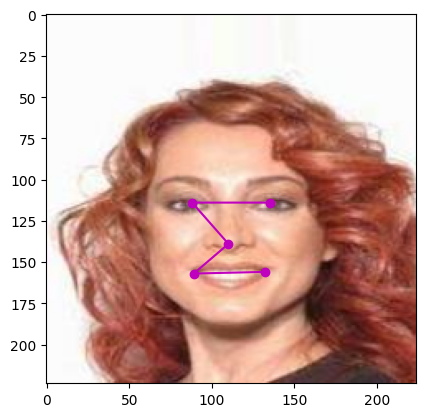

In [152]:
pred_and_plot_image_with_box(image_path='/content/data/img_align_celeba/img_align_celeba/095000.jpg', transform=test_transformer, size=original_image_size, model = model.to('cpu'))

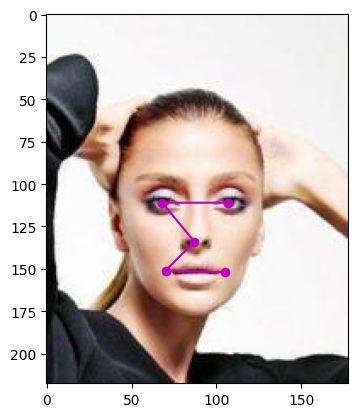

In [101]:
pred_and_plot_image_with_box(image_path='/content/data/img_align_celeba/img_align_celeba/051574.jpg', transform=test_transformer, size=original_image_size, model = model.to('cpu'))

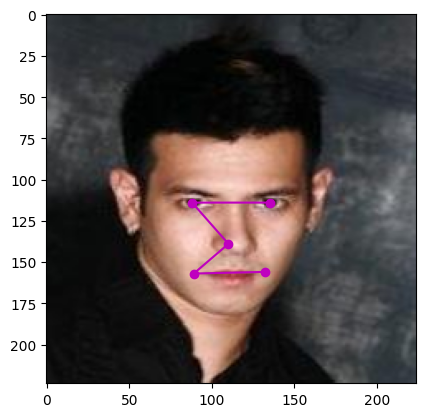

In [158]:
pred_and_plot_image_with_box(image_path='/content/data/img_align_celeba/img_align_celeba/051570.jpg', transform=test_transformer, size=original_image_size, model = model.to('cpu'))

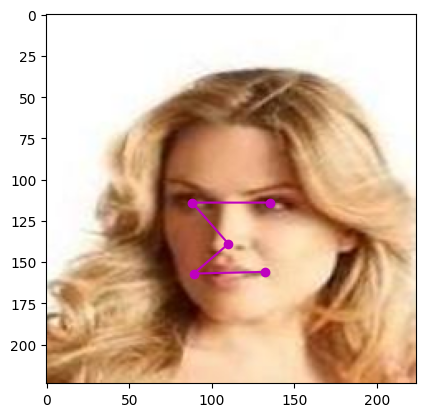

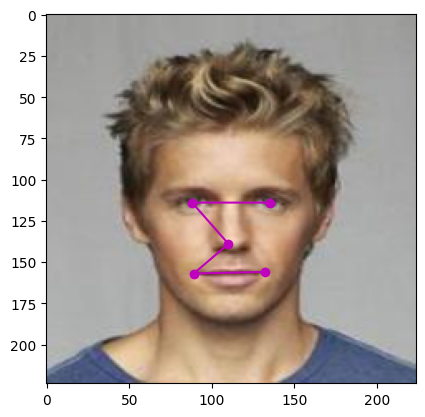

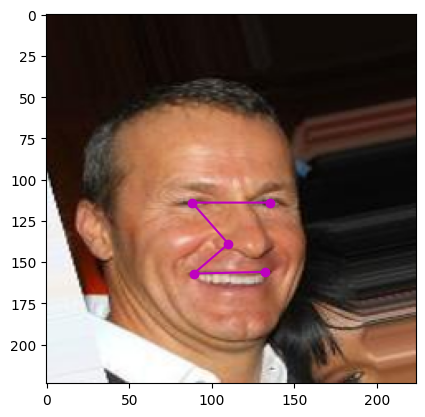

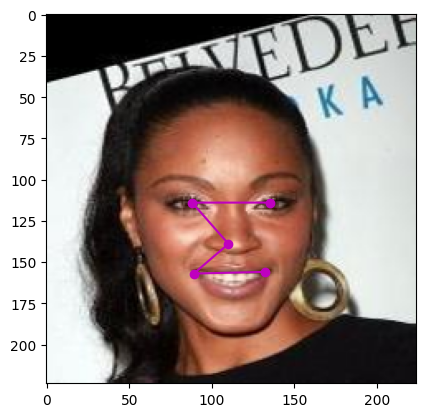

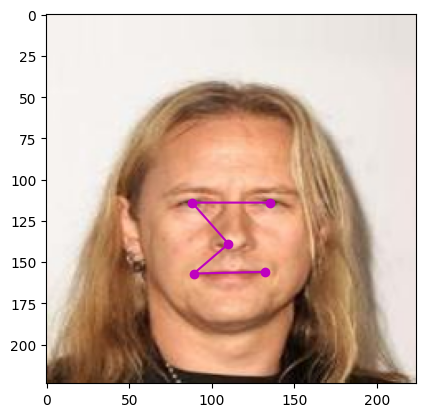

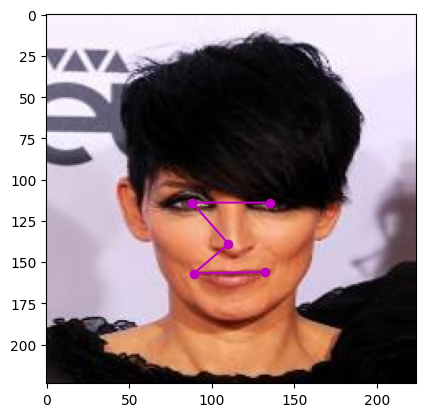

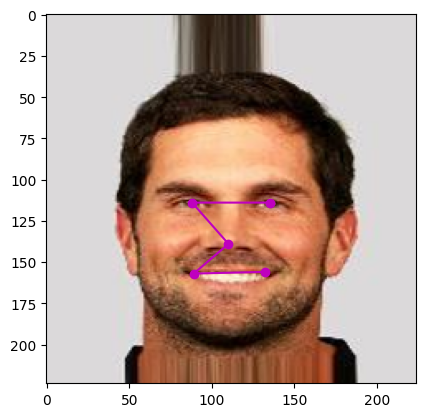

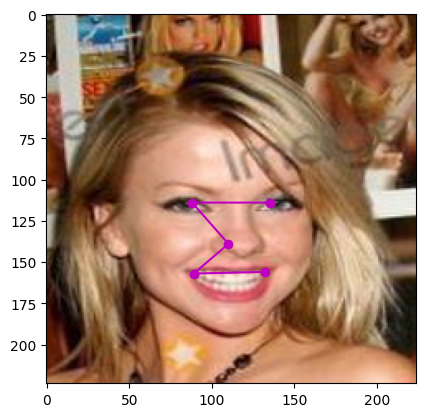

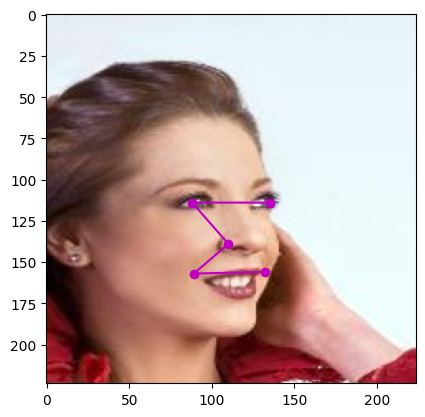

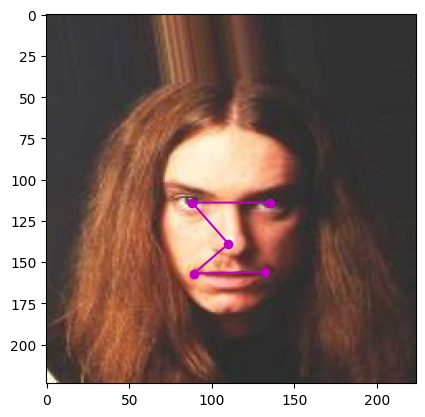

In [154]:
for i in range(30,40,1):
  pred_and_plot_image_with_box(image_path=f'/content/data/img_align_celeba/img_align_celeba/1002{i}.jpg', transform=test_transformer, size=original_image_size, model = model.to('cpu'))

In [ ]:
torch.save(model.state_dict(), f='face_landmark_model.pth')